✓ All imports successful

--- Testing Distinct-N Metrics ---

Diverse texts:
  distinct_1: 0.8333
  distinct_2: 1.0000
  distinct_3: 1.0000

Repetitive texts:
  distinct_1: 0.4286
  distinct_2: 0.7500
  distinct_3: 0.8182

--- Testing ROUGE-L Metric ---

Reference: The majestic mountain stands tall against the clear blue sky

Mean ROUGE-L scores:
  rouge_l_precision: 0.5298
  rouge_l_recall: 0.3500
  rouge_l_fmeasure: 0.4210

Individual scores:

  [1] The mountain stands tall against the sky
      F-measure: 0.8235

  [2] Mountains rise high under blue skies
      F-measure: 0.3750

  [3] The peak towers over the valley below
      F-measure: 0.2353

  [4] Tall mountains reach toward the heavens
      F-measure: 0.2500

--- Testing Self-BLEU Metric ---

Diverse texts:
  Self-BLEU: 0.0399 (lower is more diverse)

Repetitive texts:
  Self-BLEU: 0.2372 (lower is more diverse)

--- Testing Length Statistics ---
  mean_chars: 35.40
  std_chars: 3.14
  mean_words: 6.00
  std_words: 0.63
  mi

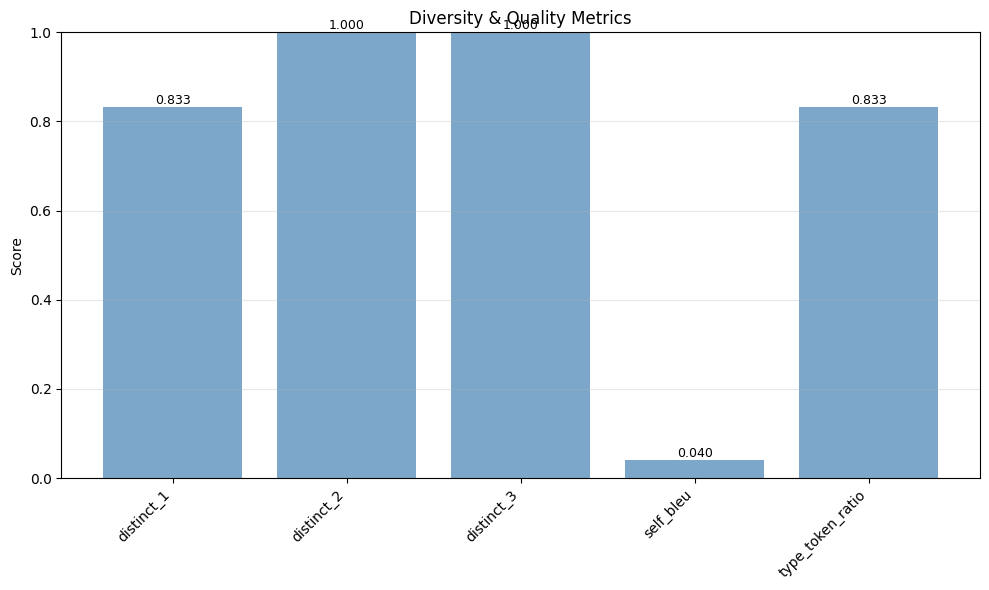

✓ Saved metrics visualization

EVALUATING RANKING QUALITY

GENERATING EVALUATION REPORT

                  name  num_candidates  distinct_1  distinct_2  distinct_3  self_bleu  mean_chars  std_chars  mean_words  std_words  min_words  max_words  vocabulary_size  total_tokens  type_token_ratio
   Diverse Generation               5    0.833333        1.00    1.000000   0.039899        35.4   3.136877         6.0   0.632456          5          7               25            30          0.833333
Repetitive Generation               5    0.428571        0.75    0.818182   0.237185        22.8   3.310589         4.2   0.748331          3          5                9            21          0.428571
✓ Saved evaluation report to data/training/evaluation_report.json
✓ Exported evaluation utilities to utils/evaluation_utils.py

✓ Notebook 5 Complete - Evaluation metrics ready!

SUMMARY
You now have complete implementations for:
  1. Generation (GPT-2/GPT-Neo)
  2. Ranking (preference embeddings + BoW)

In [4]:
# ============================================================================
# CELL 1: Installation
# ============================================================================
!pip install numpy pandas rouge-score nltk matplotlib seaborn

# ============================================================================
# CELL 2: Imports and Setup
# ============================================================================
import numpy as np
import pandas as pd
from collections import Counter
from typing import List, Dict, Tuple, Set, Optional
import json
import os
import re
from rouge_score import rouge_scorer
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

# Download NLTK data (run once)
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

print("✓ All imports successful")

# ============================================================================
# CELL 3: Distinct-N Metrics
# ============================================================================
def tokenize(text: str) -> List[str]:
    """Simple tokenization."""
    # Convert to lowercase and extract words
    tokens = re.findall(r'\b\w+\b', text.lower())
    return tokens

def compute_distinct_n(texts: List[str], n: int = 1) -> float:
    """
    Compute Distinct-N metric for a set of texts.

    Distinct-N measures lexical diversity:
    distinct_n = (# unique n-grams) / (# total n-grams)

    Args:
        texts: List of generated texts
        n: N-gram size (1 for unigrams, 2 for bigrams, etc.)

    Returns:
        Distinct-N score (0-1, higher is more diverse)
    """
    all_ngrams = []

    for text in texts:
        tokens = tokenize(text)

        # Generate n-grams
        ngrams = [
            tuple(tokens[i:i+n])
            for i in range(len(tokens) - n + 1)
        ]
        all_ngrams.extend(ngrams)

    if not all_ngrams:
        return 0.0

    unique_ngrams = len(set(all_ngrams))
    total_ngrams = len(all_ngrams)

    return unique_ngrams / total_ngrams

def compute_all_distinct_metrics(texts: List[str]) -> Dict[str, float]:
    """Compute Distinct-1, Distinct-2, and Distinct-3."""
    return {
        'distinct_1': compute_distinct_n(texts, n=1),
        'distinct_2': compute_distinct_n(texts, n=2),
        'distinct_3': compute_distinct_n(texts, n=3)
    }

# Test distinct-N
print("\n--- Testing Distinct-N Metrics ---")

test_texts_diverse = [
    "The mountain stands tall against the sky",
    "Rivers flow endlessly toward the sea",
    "Ancient forests whisper with the wind",
    "Stars shine brightly in the night",
    "Flowers bloom across the meadow"
]

test_texts_repetitive = [
    "The mountain is tall",
    "The mountain is very tall",
    "The tall mountain stands",
    "Mountains are tall",
    "The mountain is really tall"
]

print("\nDiverse texts:")
diverse_metrics = compute_all_distinct_metrics(test_texts_diverse)
for key, value in diverse_metrics.items():
    print(f"  {key}: {value:.4f}")

print("\nRepetitive texts:")
repetitive_metrics = compute_all_distinct_metrics(test_texts_repetitive)
for key, value in repetitive_metrics.items():
    print(f"  {key}: {value:.4f}")

# ============================================================================
# CELL 4: ROUGE-L Metric
# ============================================================================
def compute_rouge_l(candidates: List[str], reference: str) -> Dict[str, float]:
    """
    Compute ROUGE-L scores for candidates against a reference.

    Args:
        candidates: List of generated texts
        reference: Reference text

    Returns:
        Dictionary with mean ROUGE-L scores
    """
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

    scores = []
    for candidate in candidates:
        score = scorer.score(reference, candidate)
        scores.append({
            'precision': score['rougeL'].precision,
            'recall': score['rougeL'].recall,
            'fmeasure': score['rougeL'].fmeasure
        })

    # Compute means
    mean_scores = {
        'rouge_l_precision': np.mean([s['precision'] for s in scores]),
        'rouge_l_recall': np.mean([s['recall'] for s in scores]),
        'rouge_l_fmeasure': np.mean([s['fmeasure'] for s in scores])
    }

    return mean_scores, scores

# Test ROUGE-L
print("\n--- Testing ROUGE-L Metric ---")

reference_text = "The majestic mountain stands tall against the clear blue sky"
candidate_texts = [
    "The mountain stands tall against the sky",
    "Mountains rise high under blue skies",
    "The peak towers over the valley below",
    "Tall mountains reach toward the heavens"
]

rouge_mean, rouge_individual = compute_rouge_l(candidate_texts, reference_text)

print(f"\nReference: {reference_text}")
print("\nMean ROUGE-L scores:")
for key, value in rouge_mean.items():
    print(f"  {key}: {value:.4f}")

print("\nIndividual scores:")
for i, (cand, score) in enumerate(zip(candidate_texts, rouge_individual), 1):
    print(f"\n  [{i}] {cand}")
    print(f"      F-measure: {score['fmeasure']:.4f}")

# ============================================================================
# CELL 5: Self-BLEU (Diversity Metric)
# ============================================================================
def compute_self_bleu(texts: List[str], n: int = 4) -> float:
    """
    Compute Self-BLEU to measure diversity.

    Lower Self-BLEU indicates higher diversity (texts are less similar to each other).

    Args:
        texts: List of texts
        n: Maximum n-gram order

    Returns:
        Mean Self-BLEU score
    """
    from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

    smoothing = SmoothingFunction().method1
    scores = []

    for i, text in enumerate(texts):
        # Use all other texts as references
        references = [tokenize(t) for j, t in enumerate(texts) if j != i]
        if not references:
            continue

        candidate = tokenize(text)

        # Compute BLEU with smoothing
        try:
            score = sentence_bleu(
                references,
                candidate,
                weights=[1/n] * n,
                smoothing_function=smoothing
            )
            scores.append(score)
        except:
            pass

    return np.mean(scores) if scores else 0.0

# Test Self-BLEU
print("\n--- Testing Self-BLEU Metric ---")

print("\nDiverse texts:")
self_bleu_diverse = compute_self_bleu(test_texts_diverse)
print(f"  Self-BLEU: {self_bleu_diverse:.4f} (lower is more diverse)")

print("\nRepetitive texts:")
self_bleu_repetitive = compute_self_bleu(test_texts_repetitive)
print(f"  Self-BLEU: {self_bleu_repetitive:.4f} (lower is more diverse)")

# ============================================================================
# CELL 6: Length Statistics
# ============================================================================
def compute_length_stats(texts: List[str]) -> Dict[str, float]:
    """Compute length statistics for texts."""

    char_lengths = [len(t) for t in texts]
    word_lengths = [len(tokenize(t)) for t in texts]

    return {
        'mean_chars': np.mean(char_lengths),
        'std_chars': np.std(char_lengths),
        'mean_words': np.mean(word_lengths),
        'std_words': np.std(word_lengths),
        'min_words': min(word_lengths),
        'max_words': max(word_lengths)
    }

# Test length stats
print("\n--- Testing Length Statistics ---")
length_stats = compute_length_stats(test_texts_diverse)
for key, value in length_stats.items():
    print(f"  {key}: {value:.2f}")

# ============================================================================
# CELL 7: Vocabulary Richness
# ============================================================================
def compute_vocabulary_metrics(texts: List[str]) -> Dict[str, float]:
    """
    Compute vocabulary richness metrics.

    Includes:
    - Type-Token Ratio (TTR): unique words / total words
    - Lexical density: content words / total words
    """
    all_tokens = []
    for text in texts:
        all_tokens.extend(tokenize(text))

    if not all_tokens:
        return {
            'vocabulary_size': 0,
            'total_tokens': 0,
            'type_token_ratio': 0.0
        }

    vocab_size = len(set(all_tokens))
    total_tokens = len(all_tokens)
    ttr = vocab_size / total_tokens if total_tokens > 0 else 0

    return {
        'vocabulary_size': vocab_size,
        'total_tokens': total_tokens,
        'type_token_ratio': ttr
    }

# Test vocabulary metrics
print("\n--- Testing Vocabulary Metrics ---")
vocab_metrics = compute_vocabulary_metrics(test_texts_diverse)
for key, value in vocab_metrics.items():
    print(f"  {key}: {value if isinstance(value, int) else f'{value:.4f}'}")

# ============================================================================
# CELL 8: Comprehensive Evaluation Function
# ============================================================================
def evaluate_candidates(
    candidates: List[str],
    reference: Optional[str] = None,
    compute_rouge: bool = True
) -> Dict[str, float]:
    """
    Comprehensive evaluation of candidate texts.

    Args:
        candidates: List of generated texts
        reference: Optional reference text for ROUGE
        compute_rouge: Whether to compute ROUGE (requires reference)

    Returns:
        Dictionary of all metrics
    """
    metrics = {}

    # Distinct-N
    distinct_metrics = compute_all_distinct_metrics(candidates)
    metrics.update(distinct_metrics)

    # Self-BLEU
    if len(candidates) > 1:
        metrics['self_bleu'] = compute_self_bleu(candidates)

    # Length statistics
    length_stats = compute_length_stats(candidates)
    metrics.update(length_stats)

    # Vocabulary metrics
    vocab_metrics = compute_vocabulary_metrics(candidates)
    metrics.update(vocab_metrics)

    # ROUGE (if reference provided)
    if reference and compute_rouge:
        rouge_mean, _ = compute_rouge_l(candidates, reference)
        metrics.update(rouge_mean)

    return metrics

# Test comprehensive evaluation
print("\n" + "=" * 60)
print("COMPREHENSIVE EVALUATION")
print("=" * 60)

all_metrics = evaluate_candidates(
    test_texts_diverse,
    reference="The mountain landscape stretches far across the horizon",
    compute_rouge=True
)

print("\n--- All Metrics ---")
for key, value in sorted(all_metrics.items()):
    if isinstance(value, float):
        print(f"  {key:25s}: {value:.4f}")
    else:
        print(f"  {key:25s}: {value}")

# ============================================================================
# CELL 9: Load and Evaluate Generated Candidates
# ============================================================================
def load_and_evaluate_generation_file(filepath: str) -> Dict:
    """Load a generation file and evaluate its candidates."""

    with open(filepath, 'r') as f:
        data = json.load(f)

    candidates = data.get('candidates', [])
    metadata = data.get('metadata', {})

    print(f"\n--- Evaluating: {os.path.basename(filepath)} ---")
    print(f"Theme: {metadata.get('theme', 'unknown')}")
    print(f"Form: {metadata.get('form', 'unknown')}")
    print(f"Num candidates: {len(candidates)}")

    # Evaluate
    metrics = evaluate_candidates(candidates, compute_rouge=False)

    return {
        'filepath': filepath,
        'metadata': metadata,
        'metrics': metrics,
        'candidates': candidates
    }

# Try to load and evaluate files from notebook 1
print("\n" + "=" * 60)
print("EVALUATING GENERATED FILES")
print("=" * 60)

output_dir = 'outputs'
if os.path.exists(output_dir):
    generation_files = [
        f for f in os.listdir(output_dir)
        if f.startswith('generation_') and f.endswith('.json')
    ]

    evaluation_results = []

    for filename in generation_files[:3]:  # Evaluate first 3 files
        filepath = os.path.join(output_dir, filename)
        try:
            result = load_and_evaluate_generation_file(filepath)
            evaluation_results.append(result)

            print("\nMetrics:")
            for key, value in sorted(result['metrics'].items()):
                if isinstance(value, float):
                    print(f"  {key:20s}: {value:.4f}")
        except Exception as e:
            print(f"Error evaluating {filename}: {e}")
else:
    print("No outputs directory found. Creating sample evaluation...")
    evaluation_results = []

# ============================================================================
# CELL 10: Compare Multiple Generation Runs
# ============================================================================
def compare_generation_runs(results: List[Dict]) -> pd.DataFrame:
    """Compare metrics across multiple generation runs."""

    if not results:
        return pd.DataFrame()

    comparison_data = []
    for result in results:
        row = {
            'file': os.path.basename(result['filepath']),
            'theme': result['metadata'].get('theme', 'unknown'),
            'form': result['metadata'].get('form', 'unknown'),
            'num_candidates': len(result['candidates'])
        }
        row.update(result['metrics'])
        comparison_data.append(row)

    df = pd.DataFrame(comparison_data)
    return df

if evaluation_results:
    print("\n" + "=" * 60)
    print("COMPARISON ACROSS RUNS")
    print("=" * 60)

    comparison_df = compare_generation_runs(evaluation_results)
    print("\n", comparison_df.to_string(index=False))

    # Save comparison
    os.makedirs('data/training', exist_ok=True) # Add this line to create the directory
    comparison_df.to_csv('data/training/generation_comparison.csv', index=False)
    print("\n✓ Saved comparison to data/training/generation_comparison.csv")

# ============================================================================
# CELL 11: Visualization of Metrics
# ============================================================================
def visualize_metrics(metrics_dict: Dict[str, float], title: str = "Metrics"):
    """Visualize metrics as a bar chart."""

    # Select key metrics to visualize
    key_metrics = [
        'distinct_1', 'distinct_2', 'distinct_3',
        'self_bleu', 'type_token_ratio'
    ]

    available_metrics = {k: v for k, v in metrics_dict.items() if k in key_metrics}

    if not available_metrics:
        print("No key metrics available for visualization")
        return

    plt.figure(figsize=(10, 6))

    keys = list(available_metrics.keys())
    values = list(available_metrics.values())

    bars = plt.bar(range(len(keys)), values, color='steelblue', alpha=0.7)
    plt.xticks(range(len(keys)), keys, rotation=45, ha='right')
    plt.ylabel('Score')
    plt.title(title)
    plt.ylim(0, 1.0)
    plt.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    return plt.gcf()

# Visualize metrics from comprehensive evaluation
print("\n--- Visualizing Metrics ---")
fig = visualize_metrics(all_metrics, "Diversity & Quality Metrics")
if fig:
    os.makedirs('data/training', exist_ok=True) # Add this line to create the directory
    fig.savefig('data/training/metrics_visualization.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✓ Saved metrics visualization")

# ============================================================================
# CELL 12: Evaluate Ranking Quality
# ============================================================================
def evaluate_ranking_quality(ranked_file: str) -> Dict:
    """Evaluate the quality of a ranking."""

    with open(ranked_file, 'r') as f:
        data = json.load(f)

    ranked_candidates = data['ranked_candidates']

    # Extract texts and scores
    texts = [c['text'] for c in ranked_candidates]
    scores = [c['score'] for c in ranked_candidates]

    # Check if scores are monotonically decreasing
    is_monotonic = all(scores[i] >= scores[i+1] for i in range(len(scores)-1))

    # Score spread (how much variation in scores)
    score_spread = max(scores) - min(scores)

    # Evaluate diversity of top-k
    top_5_texts = texts[:5]
    top_5_metrics = compute_all_distinct_metrics(top_5_texts)

    return {
        'num_candidates': len(texts),
        'is_monotonic': is_monotonic,
        'score_range': (min(scores), max(scores)),
        'score_spread': score_spread,
        'score_mean': np.mean(scores),
        'score_std': np.std(scores),
        'top_5_distinct_1': top_5_metrics['distinct_1'],
        'top_5_distinct_2': top_5_metrics['distinct_2']
    }

# Try to evaluate ranking files
print("\n" + "=" * 60)
print("EVALUATING RANKING QUALITY")
print("=" * 60)

if os.path.exists('outputs'):
    ranking_files = [
        f for f in os.listdir('outputs')
        if f.startswith('ranked_') and f.endswith('.json')
    ]

    for filename in ranking_files[:2]:
        filepath = os.path.join('outputs', filename)
        try:
            print(f"\n--- {filename} ---")
            ranking_eval = evaluate_ranking_quality(filepath)

            for key, value in ranking_eval.items():
                if isinstance(value, tuple):
                    print(f"  {key}: {value}")
                elif isinstance(value, float):
                    print(f"  {key}: {value:.4f}")
                else:
                    print(f"  {key}: {value}")
        except Exception as e:
            print(f"Error: {e}")

# ============================================================================
# CELL 13: Create Evaluation Report
# ============================================================================
class EvaluationReport:
    """Generate comprehensive evaluation reports."""

    def __init__(self):
        self.results = []

    def add_evaluation(self, name: str, candidates: List[str], metadata: Dict = None):
        """Add an evaluation run."""
        metrics = evaluate_candidates(candidates, compute_rouge=False)

        self.results.append({
            'name': name,
            'metadata': metadata or {},
            'metrics': metrics,
            'num_candidates': len(candidates)
        })

    def generate_summary(self) -> pd.DataFrame:
        """Generate summary DataFrame."""
        if not self.results:
            return pd.DataFrame()

        data = []
        for result in self.results:
            row = {
                'name': result['name'],
                'num_candidates': result['num_candidates'],
                **result['metrics']
            }
            data.append(row)

        return pd.DataFrame(data)

    def save_report(self, filepath: str = 'data/training/evaluation_report.json'):
        """Save full report to JSON."""
        os.makedirs(os.path.dirname(filepath), exist_ok=True) # Add this line to create the directory
        with open(filepath, 'w') as f:
            json.dump({
                'timestamp': pd.Timestamp.now().isoformat(),
                'num_evaluations': len(self.results),
                'results': self.results
            }, f, indent=2)

        print(f"✓ Saved evaluation report to {filepath}")

# Create sample report
print("\n" + "=" * 60)
print("GENERATING EVALUATION REPORT")
print("=" * 60)

report = EvaluationReport()

# Add evaluations
report.add_evaluation(
    "Diverse Generation",
    test_texts_diverse,
    {'description': 'Highly diverse candidate set'}
)

report.add_evaluation(
    "Repetitive Generation",
    test_texts_repetitive,
    {'description': 'Low diversity candidate set'}
)

# Generate summary
summary_df = report.generate_summary()
print("\n", summary_df.to_string(index=False))

# Save report
report.save_report()

# ============================================================================
# CELL 14: Metric Correlations
# ============================================================================
def analyze_metric_correlations(results: List[Dict]) -> pd.DataFrame:
    """Analyze correlations between different metrics."""

    if len(results) < 3:
        print("Need at least 3 evaluation runs to analyze correlations")
        return None

    # Extract metrics into DataFrame
    metric_data = []
    for result in results:
        metric_data.append(result['metrics'])

    df = pd.DataFrame(metric_data)

    # Select numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    # Compute correlation matrix
    corr_matrix = df[numeric_cols].corr()

    # Visualize
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
                center=0, square=True, linewidths=1)
    plt.title('Metric Correlations')
    plt.tight_layout()
    os.makedirs('data/training', exist_ok=True) # Add this line to create the directory
    plt.savefig('data/training/metric_correlations.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("✓ Saved correlation heatmap")

    return corr_matrix

# ============================================================================
# CELL 15: Export Utilities
# ============================================================================
def export_evaluation_functions(output_file: str = 'utils/evaluation_utils.py'):
    """
    Export evaluation functions for use in main codebase.
    This would contain all the evaluation functions defined above.
    """

    os.makedirs('utils', exist_ok=True)

    functions_code = '''"""
Evaluation utilities for reciprocal poetry generation.
Generated from notebook 05.
"""

import numpy as np
from typing import List, Dict, Optional
from collections import Counter
import re
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def tokenize(text: str) -> List[str]:
    """Simple tokenization."""
    tokens = re.findall(r'\\b\\w+\\b', text.lower())
    return tokens

def compute_distinct_n(texts: List[str], n: int = 1) -> float:
    """Compute Distinct-N metric for lexical diversity."""
    all_ngrams = []

    for text in texts:
        tokens = tokenize(text)
        ngrams = [tuple(tokens[i:i+n]) for i in range(len(tokens) - n + 1)]
        all_ngrams.extend(ngrams)

    if not all_ngrams:
        return 0.0

    return len(set(all_ngrams)) / len(all_ngrams)

# Add other functions here...
'''

    with open(output_file, 'w') as f:
        f.write(functions_code)

    print(f"✓ Exported evaluation utilities to {output_file}")

export_evaluation_functions()

print("\n✓ Notebook 5 Complete - Evaluation metrics ready!")
print("\n" + "=" * 60)
print("SUMMARY")
print("=" * 60)
print("You now have complete implementations for:")
print("  1. Generation (GPT-2/GPT-Neo)")
print("  2. Ranking (preference embeddings + BoW)")
print("  3. Profile management (EWA updates)")
print("  4. Reward model (MLP trainer)")
print("  5. Evaluation metrics (Distinct-N, ROUGE, Self-BLEU)")
print("\nNext step: Convert notebooks to production code structure!")